In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

os.environ['KERAS_BACKEND'] = 'tensorflow'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 13.2 MB/s eta 0:00:00a 0:00:01


In [3]:
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Using TensorFlow backend
TensorFlow version: 2.12.0
KerasNLP version: 0.6.1


# > **Reading Dataset**

In [4]:
# Loading the training and test datasets
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Displaying information about the datasets
print('Training Set:')
print('Shape: {}'.format(df_train.shape))
print('Memory Usage: {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

print('\nTest Set:')
print('Shape: {}'.format(df_test.shape))
print('Memory Usage: {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))


Training Set:
Shape: (7613, 5)
Memory Usage: 0.29 MB

Test Set:
Shape: (3263, 4)
Memory Usage: 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# Calculating the length of each text in the training dataset and create a new column
df_train["length"] = df_train["text"].apply(lambda x: len(x))

# Calculating the length of each text in the test dataset and create a new column
df_test["length"] = df_test["text"].apply(lambda x: len(x))

# Display statistics about text lengths in the training dataset
print("Train Length Statistics:")
print(df_train["length"].describe())
print()

# Display statistics about text lengths in the test dataset
print("Test Length Statistics:")
print(df_test["length"].describe())

Train Length Statistics:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Statistics:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [8]:
# Constants for batch processing and training
batch_size = 32
no_training_example = df_train.shape[0]
train_split = 0.8
validation_split = 0.2

# Calculate the number of steps per epoch for the training process
steps_per_epoch = int(no_training_example * train_split) // batch_size

# Number of training epochs
epochs = 5

# Use AUTOTUNE for optimizing input data pipeline
AUTO = tf.data.experimental.AUTOTUNE


In [9]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)

X_test = df_test["text"]

In [10]:
# Load a DistilBERT model.
preset = "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor=preprocessor,
                                                               num_classes=2)

# Display model summary
classifier.summary()

231508/231508 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       
265570304/265570304 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │  66,362,880 │ padding_mask[0][0],            │
│ (DistilBertBackbone)          │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │           0 │ distil_bert_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │     590,592 │ get_item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │           0 │ pooled_dense[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │       1,538 │ classifier_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 66,955,010 (2.00 GB)

 Trainable params: 66,955,010 (2.00 GB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Adjusted learning rate
    metrics=["accuracy"]
)

# Fit the model
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,  # Using the defined batch_size
    epochs=epochs,
    validation_data=(X_val, y_val)
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 606ms/step - accuracy: 0.7333 - loss: 0.5563 - val_accuracy: 0.8372 - val_loss: 0.3945
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 447ms/step - accuracy: 0.8431 - loss: 0.3789 - val_accuracy: 0.8391 - val_loss: 0.3910
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.8761 - loss: 0.3225 - val_accuracy: 0.8418 - val_loss: 0.3961
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.8950 - loss: 0.2822 - val_accuracy: 0.8378 - val_loss: 0.4143
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 424ms/step - accuracy: 0.9135 - loss: 0.2441 - val_accuracy: 0.8240 - val_loss: 0.4564


In [12]:
from sklearn.metrics import confusion_matrix, f1_score

def displayConfusionMatrix(y_true, y_pred, dataset):
    # Generate confusion matrix display
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    
    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    
    # Calculate F1 score
    f1 = f1_score(y_true, np.argmax(y_pred, axis=1))
    
    # Set title for the confusion matrix plot
    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1 Score: {f1:.2f}")

191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step


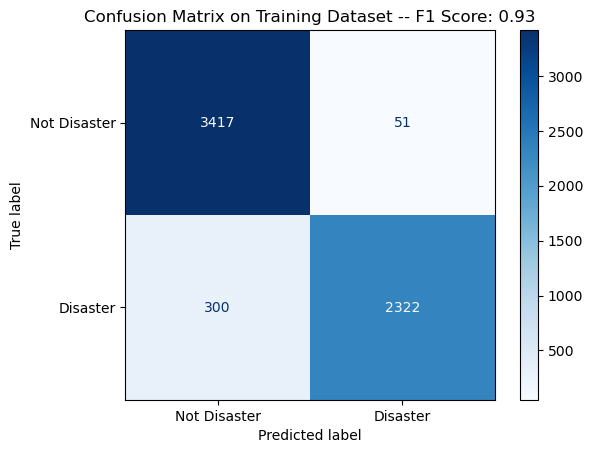

In [13]:
y_pred_train = classifier.predict(X_train)
displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step


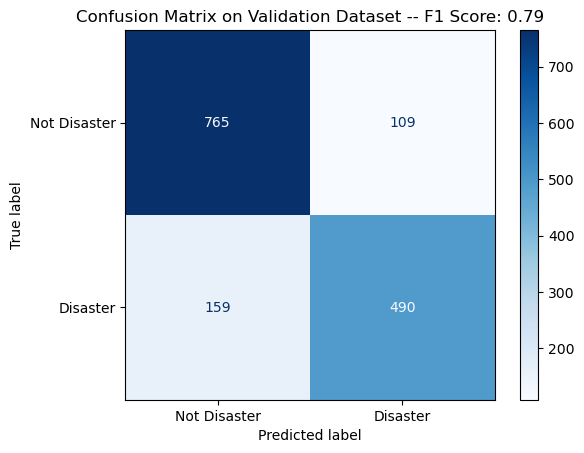

In [14]:
y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [16]:
# sample_submission = pd.read_csv("sample_submission.csv")
# sample_submission.head()

In [17]:
# sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

In [18]:
# sample_submission.describe()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)